# Smoothed InfoNCE

## Setup

In [16]:
import torch
import torch.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt
import argparse
from src.utils import *
from src.mi_estimators import *
from torch.utils.tensorboard import SummaryWriter

In [17]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
torch.set_default_tensor_type(FloatTensor)

In [18]:
parser = argparse.ArgumentParser()
parser.add_argument("--rho", type=float, default=0.9, help="coefficient of Gaussian")
parser.add_argument("--d", type=int, default=20, help="dimension of X & Y")
parser.add_argument("--sample_size", type=int, default=400, help="sample size")
parser.add_argument("--gamma", type=float, default=1e-10, help="clipping parameter")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--batch_size", type=int, default=40, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-3, help="adam: learning rate")
parser.add_argument("--hidden_dim", type=int, default=100, help="Hidden dimension")
parser.add_argument("--ma_rate", type=float, default=0.1, help="move average rate")
parser.add_argument("--ma_ef", type=float, default=1, help="move average ef")
parser.add_argument("--alpha", type=float, default=1e-6, help="smooth parameter")
parser.add_argument("--reg", type=int, default=1, help="if apply regularization")
parser.add_argument("--n_epoch", type=int, default=2000, help="number of epochs of training")
parser.add_argument("--n_iters_1epoch", type=int, default=10, help="number of epochs of training")

opt, unknown = parser.parse_known_args()
opt.n_iters = opt.n_epoch * opt.n_iters_1epoch
ma_rate = 0.01  # moving average rate

In [19]:
continue_train = True  # set to True to continue to train
load_available = False # set to False to prevent loading previous results
overwrite = False  # set to True to overwrite previously stored results

Generate the data.

In [20]:
data = GaussianData(opt.sample_size, d=opt.d, rho=opt.rho)
X, Y, XY, Ground_truth = data.X, data.Y, torch.cat((data.X, data.Y), dim=1), data.mutual_information()

In [21]:
# choose n marginal samples to train DT
ref_X, ref_Y = shuffle_data(X, Y, opt.sample_size)
ref_XY = torch.cat([ref_X, ref_Y], dim = 1)
train_data = torch.cat([XY, ref_XY], dim = 0)
train_label = torch.cat([torch.ones([opt.sample_size,1]), torch.zeros([opt.sample_size, 1])], dim=0)

Train Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

clf = DecisionTreeClassifier(min_samples_leaf=20, max_depth=20)
# clf = DecisionTreeClassifier(min_samples_leaf=400, max_depth=10)
# clf = RandomForestClassifier(n_estimators=10, min_samples_split=5)
clf.fit(train_data.cpu().numpy(),  train_label.cpu().numpy())

DecisionTreeClassifier(max_depth=20, min_samples_leaf=20)

In [23]:
path = clf.cost_complexity_pruning_path(train_data.cpu().numpy(), train_label.cpu().numpy())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Choose the confidence factor

In [24]:
ccp = ccp_alphas[round(len(ccp_alphas)/2)]
clf = DecisionTreeClassifier(min_samples_leaf=20, max_depth=20, ccp_alpha=ccp)
clf.fit(train_data.cpu().numpy(),  train_label.cpu().numpy())

DecisionTreeClassifier(ccp_alpha=0.0030251936123911922, max_depth=20,
                       min_samples_leaf=20)

The score of DT.

In [25]:
clf.score(train_data.cpu().numpy(),  train_label.cpu().numpy())

0.76125

In [26]:
# construct the data needs to train and predict the label
x_tile = X.unsqueeze(0).repeat((opt.sample_size, 1, 1))
y_tile = Y.unsqueeze(1).repeat((1, opt.sample_size, 1))
data_matrix = torch.cat([x_tile, y_tile], dim = -1)
DT_prob_matrix = torch.Tensor(clf.predict_proba(data_matrix.reshape(-1, opt.d*2).cpu().numpy())[:,1].reshape(opt.sample_size, opt.sample_size))

## Initialize the model.

In [27]:
name = f'./results/Smoothed_InfoNCE_dim{opt.d}_reg{opt.reg}_alpha{opt.alpha}'   # filename
chkpt_name = name+'.pt'      # checkpoint

from datetime import datetime
TIMESTAMP = "{0:%Y-%m-%dT%H-%M-%S/}".format(datetime.now())
writer = SummaryWriter(f'./results/log/Smoothed_InfoNCE_dim{opt.d}_reg{opt.reg}_alpha{opt.alpha}/{TIMESTAMP}')
discriminator = Net(input_size=opt.d*2, hidden_layers=2, hidden_size=100)

# move NN model to GPU if GPU is available
if cuda:
    discriminator.cuda()

# Adam optimizer
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [28]:
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    mi_list = checkpoint['mi_list']
    model_state = checkpoint['model_state']
    discriminator.load_state_dict(model_state)
    print('Previous results loaded.')
else:
    mi_list = [] # storing the mi estimation of each iteration

In [29]:
def smooth_loss(net, prob_matrix, xy_data, alpha, writer=None, epoch=None, reg=False):
    batch_size = xy_data.shape[0]
    hard_label = torch.eye(batch_size)
    prob_matrix = alpha*prob_matrix + hard_label*(1-alpha)
    prob_matrix_0 = 1-prob_matrix
    t_mat = net(xy_data).squeeze(-1)

    qt_matrix = t_mat*prob_matrix
    weight_qt_mat = torch.diag_embed(qt_matrix.diag())+ (qt_matrix-torch.diag_embed(qt_matrix.diag()))/(batch_size-1)
    a = weight_qt_mat.sum(axis=1).mean()

    # second term
    qet_weight = torch.log(torch.diag_embed(prob_matrix_0.diag())+ (prob_matrix_0-torch.diag_embed(prob_matrix_0.diag()))/(batch_size-1))
    b = (qet_weight+t_mat).logsumexp(dim=1).mean()


    # The following implementation sometimes will lead to inf due to the exp function, instead, we 
    # recommand to use logsumexp to avoid instability issue.
    # qet_matrix = t_mat.exp()*(1-prob_matrix)
    # weight_qet_mat = torch.diag_embed(qet_matrix.diag())+ (qet_matrix-torch.diag_embed(qet_matrix.diag()))/(batch_size-1)
    # b = torch.log(weight_qet_mat.sum(axis=1)).mean()
    
    if writer is not None:
        writer.add_scalar('a', a, epoch)
        writer.add_scalar('b', b, epoch)

    if reg:
        return a - b - b**2
    else:
        return a - b

In [30]:
if continue_train:
    _iter = 0
    for i in range(opt.n_epoch):
        idx = np.random.permutation(opt.sample_size)
        for j in range(opt.n_iters_1epoch):
            batch_idx = idx[j::opt.n_iters_1epoch]
            # select the minibatch of the data
            data_batch = data_matrix[np.ix_(batch_idx, batch_idx)] # size: [batch_size*batch_size]
            prob_batch = DT_prob_matrix[np.ix_(batch_idx, batch_idx)] # size: [batch_size*batch_size]

            optimizer_D.zero_grad()
            loss = - smooth_loss(discriminator, prob_batch, data_batch, alpha=opt.alpha, reg=opt.reg) # negative infonce_bound as the loss
            loss.backward()

            optimizer_D.step()
            with torch.no_grad():
                mi_est = smooth_loss(discriminator, DT_prob_matrix, data_matrix, alpha=opt.alpha)
            mi_list.append(mi_est.item())

            writer.add_scalar('mi_list', mi_est.item(), _iter)
            writer.add_scalar('loss', loss, _iter)
        _iter += 1
        if _iter%200==0:
            print("Iternation: %d, loss: %f, mi_est: %f"%(_iter, loss.item(), mi_est))
            fig = plot_fig(discriminator, X, Y, opt.d if opt.d<6 else 6)
            writer.add_figure('heatmap', fig, _iter)
            writer.add_histogram('first layer', discriminator.fc[0].weight.data, _iter)
            writer.add_histogram('second layer', discriminator.fc[1].weight.data, _iter)
            writer.add_histogram('third layer', discriminator.fc[2].weight.data, _iter)

            writer.add_histogram('first layer (grad)', discriminator.fc[0].weight.grad.data, _iter)
            writer.add_histogram('second layer (grad)', discriminator.fc[1].weight.grad.data, _iter)
            writer.add_histogram('third layer (grad)', discriminator.fc[2].weight.grad.data, _iter)

writer.add_graph(discriminator, (XY,))
writer.close()

Iternation: 200, loss: -12.601323, mi_est: 13.487880
Iternation: 400, loss: -10.025316, mi_est: 14.082619
Iternation: 600, loss: -14.787738, mi_est: 14.622247
Iternation: 800, loss: -15.042752, mi_est: 14.699948
Iternation: 1000, loss: -15.150310, mi_est: 14.826239
Iternation: 1200, loss: -14.645342, mi_est: 14.742653
Iternation: 1400, loss: -15.029571, mi_est: 14.987610
Iternation: 1600, loss: -14.408251, mi_est: 15.025175
Iternation: 1800, loss: -15.025264, mi_est: 15.081062
Iternation: 2000, loss: -15.199494, mi_est: 15.073311


In [31]:
if overwrite or not os.path.exists(chkpt_name):
    model_state = discriminator.state_dict()
    torch.save({
        'mi_list': mi_list,
        'model_state': model_state
    }, chkpt_name)
    writer.close()
    print('Current results saved.')

Current results saved.


In [32]:
mi_copy = mi_list.copy()
for k in range(1,len(mi_list)):
    mi_copy[k] = (1-ma_rate) * mi_copy[k-1] + ma_rate * mi_copy[k]

KSG estimator

In [33]:
import src.entropy_estimators as ee

KSG = ee.mi(X.cpu().numpy(),Y.cpu().numpy())

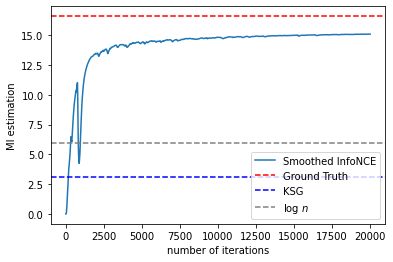

In [34]:
plt.plot(mi_copy, label='Smoothed InfoNCE')

plt.axhline(Ground_truth,label='Ground Truth',linestyle='--',color='red')
plt.axhline(KSG,label='KSG',linestyle='--',color='blue')
plt.axhline(np.log(opt.sample_size),label='log $n$',linestyle='--',color='grey')
plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
# plt.title('MI estimation with Smoothed InfoNCE')
plt.legend()
# plt.savefig(f'results/Smoothed_InfoNCE_dim{opt.d}_ma{ma_rate}.pdf')

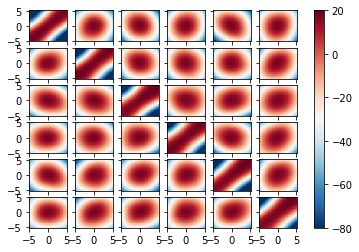

In [35]:
heatmap = plot_fig(discriminator, X, Y, vmin=-80, vmax=20, d=6)
# plt.savefig(f'./results/heatmap_smoothed_InfoNCE_dim{opt.d}.pdf')